In [ ]:
! pip install git+https://github.com/Mcamilo/tpot-clustering.git

## Why Use TPOTClustering?

Clustering performance is highly sensitive to preprocessing — scaling, normalization, or even projections like PCA can drastically change cluster shapes.

Rather than hand-crafting preprocessing steps, `TPOTClustering` automatically searches over pipelines to optimize clustering performance, here using silhouette score.

Below, we compare:
- Raw KMeans (no preprocessing)
- TPOT-optimized pipeline (with preprocessing + clustering)

We visualize:
1. The original data (colored by ground-truth class labels)
2. Clustering results (without and with preprocessing)
3. How TPOT transforms the data to improve clustering quality


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from tpotclustering import TPOTClustering

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/dermatology/dermatology.data"

column_names = [
    "erythema", "scaling", "definite_borders", "itching", "koebner_phenomenon",
    "polygonal_papules", "follicular_papules", "oral_mucosal_involvement", "knee_and_elbow_involvement",
    "scalp_involvement", "family_history", "melanin_incontinence", "eosinophils_in_the_infiltrate",
    "PNL_infiltrate", "fibrosis_of_the_papillary_dermis", "exocytosis", "acanthosis",
    "hyperkeratosis", "parakeratosis", "clubbing_of_the_rete_ridges", "elongation_of_the_rete_ridges",
    "thinning_of_the_suprapapillary_epidermis", "spongiform_pustule", "munro_microabcess",
    "focal_hypergranulosis", "disappearance_of_the_granular_layer", "vacuolisation_and_damage_of_basal_layer",
    "spongiosis", "saw_tooth_appearance_of_retes", "follicular_horn_plug", "perifollicular_parakeratosis",
    "inflammatory_monoluclear_inflitrate", "band_like_infiltrate", "Age", "Class"
]

df = pd.read_csv(url, names=column_names, index_col=False)
df.replace('?', np.nan, inplace=True)
df["Age"] = pd.to_numeric(df["Age"], errors='coerce')
df["Age"].fillna(df["Age"].median(), inplace=True)

# Separate features and labels
X_raw = df.drop(columns=["Class"])
y_true = df["Class"]

/tmp/ipykernel_835109/115372005.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Age"].fillna(df["Age"].median(), inplace=True)


### Why Preprocessing Matters

Before clustering, it’s important to examine the raw dataset. Below:

- The **PCA scatter plot** shows the projection of the unscaled data. Since PCA is sensitive to feature variance, high-scale features dominate the result, hiding structure in lower-variance dimensions.
- The **boxplots** show that there are features on different scales. Clustering algorithms like KMeans are distance-based, and will be biased toward features with large numeric ranges unless the data is standardized.

This motivates the need for automatic preprocessing, one of the strengths of TPOTClustering.


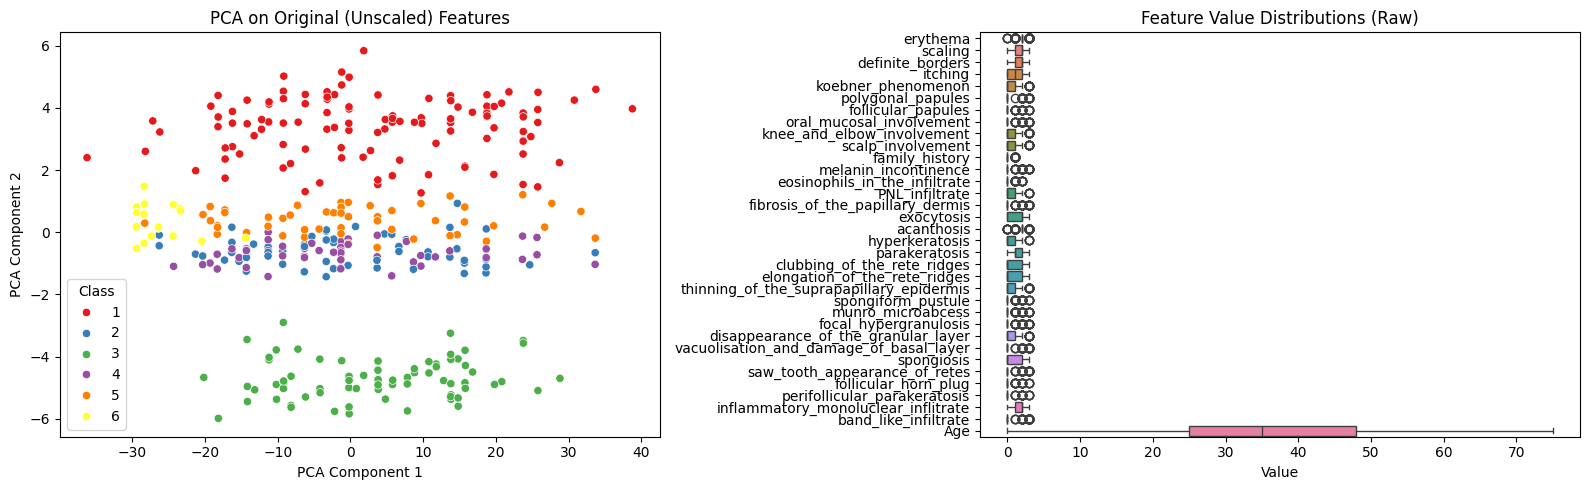

In [9]:
# PCA on unscaled data
pca = PCA(n_components=2)
X_pca_unscaled = pca.fit_transform(X_raw)

# Plot setup
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# 1. PCA plot on unscaled data
sns.scatterplot(x=X_pca_unscaled[:, 0], y=X_pca_unscaled[:, 1], hue=y_true, palette="Set1", ax=axs[0], legend='full')
axs[0].set_title("PCA on Original (Unscaled) Features")
axs[0].set_xlabel("PCA Component 1")
axs[0].set_ylabel("PCA Component 2")

# 2. Boxplot of feature distributions
sns.boxplot(data=X_raw, orient="h", ax=axs[1])
axs[1].set_title("Feature Value Distributions (Raw)")
axs[1].set_xlabel("Value")

plt.tight_layout()
plt.show()

                                                                             
Generation 1 - Current best internal CV score: 0.3878875625780709
                                                                             
Generation 2 - Current best internal CV score: 0.5002115627255318
                                                                             
Generation 3 - Current best internal CV score: 0.5002115627255318
                                                                              
Generation 4 - Current best internal CV score: 0.5032296138381243
                                                                              
Generation 5 - Current best internal CV score: 0.5067521394054466
                                                                              
Generation 6 - Current best internal CV score: 0.5437813671197567
                                                                              
Generation 7 - Current best internal CV score: 0.54378

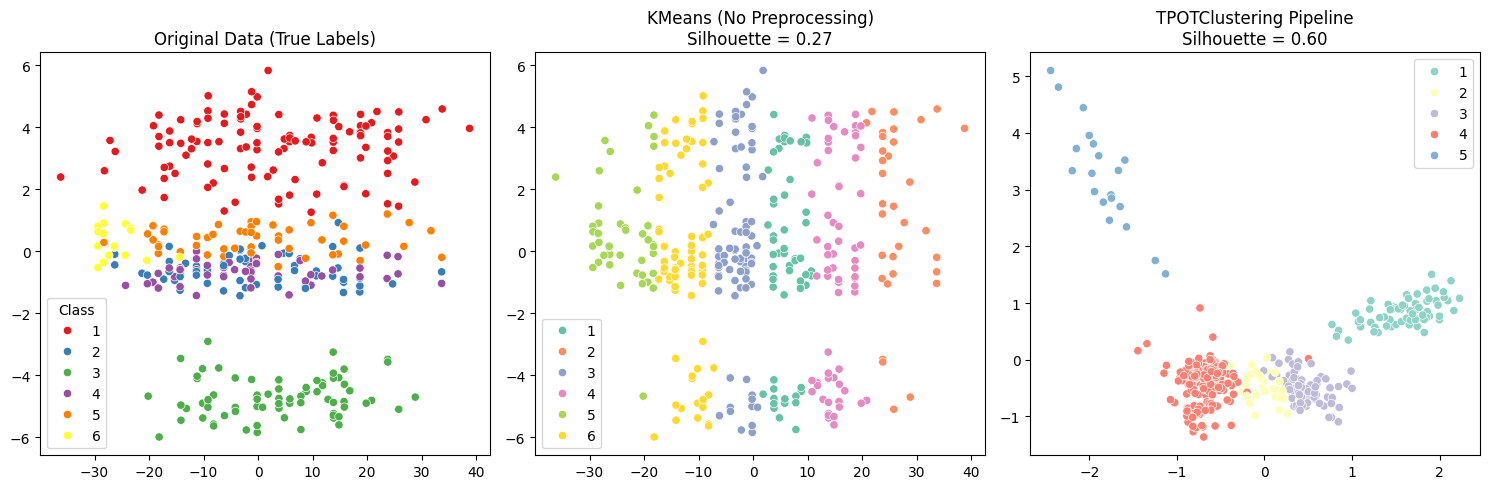

In [10]:
# Raw KMeans pipeline (no preprocessing)
pipeline_raw = Pipeline([
    ('kmeans', KMeans(n_clusters=len(np.unique(y_true)), random_state=42))
])
y_pred_raw = pipeline_raw.fit_predict(X_raw)

# TPOT clustering pipeline (auto with preprocessing)
tpot_clustering = TPOTClustering(generations=10, population_size=20, verbosity=2, random_state=42, scoring="silhouette_score")
tpot_clustering.fit(X_raw)
fitted_pipeline = tpot_clustering.fitted_pipeline_

y_pred_tpot = fitted_pipeline.fit_predict(X_raw)

# PCA projections
pca = PCA(n_components=2)
X_pca_true = pca.fit_transform(X_raw)  # original data, unprocessed

X_transformed_tpot = fitted_pipeline[:-1].transform(X_raw)  # all but final step (usually kmeans)
X_pca_tpot = pca.fit_transform(X_transformed_tpot)

# Compute silhouette scores using their respective feature sets
silhouette_raw = silhouette_score(X_raw, y_pred_raw)
silhouette_tpot = silhouette_score(X_transformed_tpot, y_pred_tpot)

# Plotting
plt.figure(figsize=(15, 5))

# Original data with true labels
plt.subplot(1, 3, 1)
sns.scatterplot(x=X_pca_true[:, 0], y=X_pca_true[:, 1], hue=y_true, palette="Set1", legend="full")
plt.title("Original Data (True Labels)")

# Clustering without preprocessing
plt.subplot(1, 3, 2)
sns.scatterplot(x=X_pca_true[:, 0], y=X_pca_true[:, 1], hue=y_pred_raw + 1, palette="Set2", legend="full")
plt.title(f"KMeans (No Preprocessing)\nSilhouette = {silhouette_raw:.2f}")

# Clustering with TPOT pipeline
plt.subplot(1, 3, 3)
sns.scatterplot(x=X_pca_tpot[:, 0], y=X_pca_tpot[:, 1], hue=y_pred_tpot + 1, palette="Set3", legend="full")
plt.title(f"TPOTClustering Pipeline\nSilhouette = {silhouette_tpot:.2f}")

plt.tight_layout()
plt.show()


## Auto Data transformation

TPOT-clustering discovered transformations that reshape the feature space to make natural groupings more compact and better separated, which improves silhouette score.

/tmp/ipykernel_835109/1547919753.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X_pca_tpot[:, 0], y=X_pca_tpot[:, 1], palette="muted")


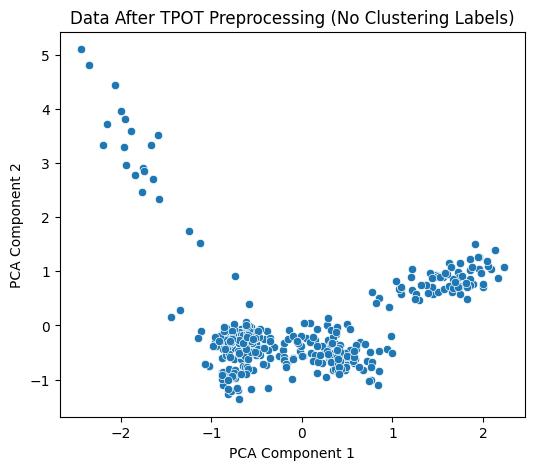

In [2]:
# Visualize data after TPOT preprocessing, before clustering
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca_tpot[:, 0], y=X_pca_tpot[:, 1], palette="muted")
plt.title("Data After TPOT Preprocessing (No Clustering Labels)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


## TPOT Pipeline Analysis

The automated pipeline synthesized by TPOT-Clustering is:

```python
KMeans(FastICA(StandardScaler(input_matrix), n_components=3), init=random, n_clusters=5)
```

This pipeline performs the following transformations:
1. **StandardScaler**: Normalizes all features to have zero mean and unit variance
2. **FastICA (n_components=3)**: Independent Component Analysis that:
   - Reduces dimensionality to 3 components
   - Finds components that are statistically independent
3. **KMeans (n_clusters=5, init=random)**: Clustering step that:
   - Groups data into 5 clusters
   - Uses random initialization for centroids

The visualizations show:
- Left: PCA projection of the transformed features colored by true labels
- Right: Distribution of values in the transformed feature space

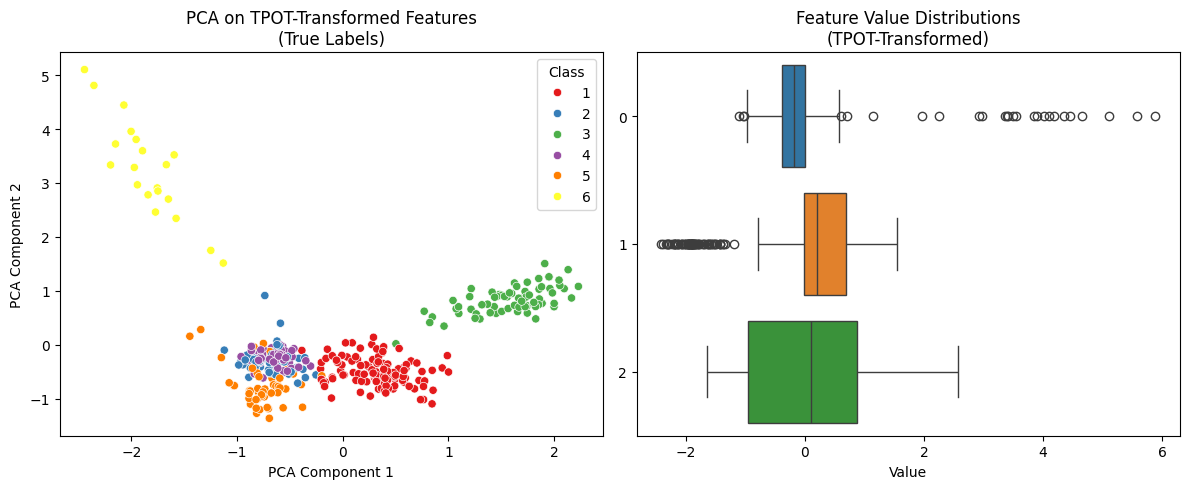

In [16]:
# TPOT-Transformed Data Visualization
# Pipeline: KMeans(FastICA(StandardScaler(input_matrix), n_components=3), init=random, n_clusters=5)

# Get TPOT transformed data (excluding the final clustering step)
X_transformed_tpot = fitted_pipeline[:-1].transform(X_raw)

# PCA on TPOT-transformed data
pca = PCA(n_components=2)
X_pca_tpot = pca.fit_transform(X_transformed_tpot)

# Plot setup
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# 1. PCA plot on TPOT-transformed data (true labels)
sns.scatterplot(x=X_pca_tpot[:, 0], y=X_pca_tpot[:, 1], 
                hue=y_true, palette="Set1", ax=axs[0], legend='full')
axs[0].set_title("PCA on TPOT-Transformed Features\n(True Labels)")
axs[0].set_xlabel("PCA Component 1")
axs[0].set_ylabel("PCA Component 2")

# 2. Boxplot of TPOT-transformed feature distributions
sns.boxplot(data=X_transformed_tpot, orient="h", ax=axs[1])
axs[1].set_title("Feature Value Distributions\n(TPOT-Transformed)")
axs[1].set_xlabel("Value")

plt.tight_layout()
plt.show()

## Overall CVI scores

TPOT-clustering pipeline with preprocessing steps improved overall the Clustering Validity Indices.

In [4]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

print("=== Clustering Scores ===")
print("Raw KMeans:")
print(f"  Silhouette: {silhouette_score(X_raw, y_pred_raw):.2f}")
print(f"  Calinski-Harabasz: {calinski_harabasz_score(X_raw, y_pred_raw):.2f}")
print(f"  Davies-Bouldin: {davies_bouldin_score(X_raw, y_pred_raw):.2f}")

print("TPOT Pipeline:")
print(f"  Silhouette: {silhouette_score(X_transformed_tpot, y_pred_tpot):.2f}")
print(f"  Calinski-Harabasz: {calinski_harabasz_score(X_transformed_tpot, y_pred_tpot):.2f}")
print(f"  Davies-Bouldin: {davies_bouldin_score(X_transformed_tpot, y_pred_tpot):.2f}")


=== Clustering Scores ===
Raw KMeans:
  Silhouette: 0.27
  Calinski-Harabasz: 483.62
  Davies-Bouldin: 1.12
TPOT Pipeline:
  Silhouette: 0.60
  Calinski-Harabasz: 975.17
  Davies-Bouldin: 0.57
